In [1]:
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.metrics
from sklearn.datasets import load_iris

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

import lime,shap,eli5,skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer
from pdpbox import pdp, get_dataset, info_plots

shap.initjs()

ModuleNotFoundError: No module named 'xgboost'

## 读取数据

In [2]:
feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country"]
data = np.genfromtxt('data/adult.data', delimiter=', ', dtype=str)
data = pd.DataFrame(data, columns=feature_names+['label'])

## 数据的基本信息

In [7]:
data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null object
Workclass         32561 non-null object
fnlwgt            32561 non-null object
Education         32561 non-null object
Education-Num     32561 non-null object
Marital Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital Gain      32561 non-null object
Capital Loss      32561 non-null object
Hours per week    32561 non-null object
Country           32561 non-null object
label             32561 non-null object
dtypes: object(15)
memory usage: 3.7+ MB


## 数据预处理

In [3]:
data['label'] = data['label'].apply(lambda x:0 if x == '<=50K' else 1)
labels = data['label']

categorical_features = [1,3,5, 6,7,8,9,13]

categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data.iloc[:, feature])
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_
    
data[feature_names] = data[feature_names].astype(float)

In [4]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(data[feature_names], labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(26048, 14) (6513, 14)


## 训练XGB模型

In [6]:
gbtree = xgb.XGBClassifier(n_estimators=2000, max_depth=5, learning_rate=0.05, n_jobs=8)
gbtree.fit(X_train, y_train,eval_set=[(X_test, y_test)], eval_metric='auc', verbose=100, early_stopping_rounds=100)

[0]	validation_0-auc:0.881141
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.924482
[200]	validation_0-auc:0.929456
[300]	validation_0-auc:0.930156
[400]	validation_0-auc:0.930509
[500]	validation_0-auc:0.930353
Stopping. Best iteration:
[427]	validation_0-auc:0.930578



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 绘制xgb自带的特征重要性

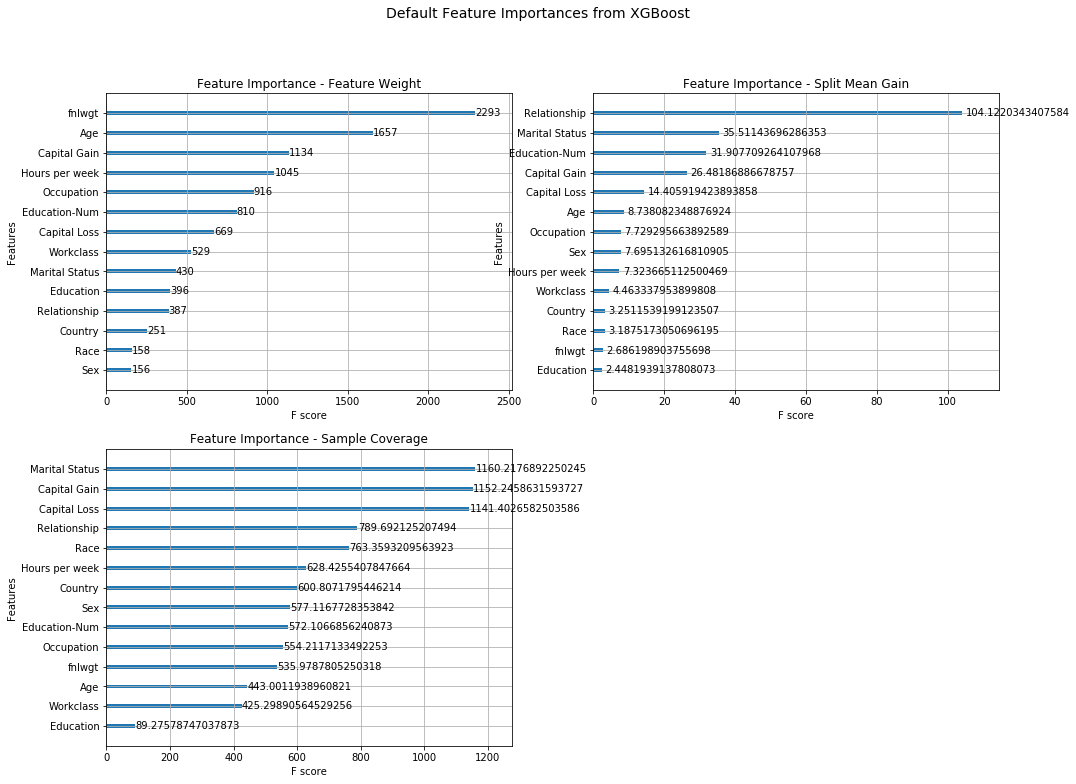

In [7]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(gbtree, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(gbtree, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(gbtree, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

## eli5计算特征重要性

In [6]:
# 默认得到的是xgb-gain的特征重要性

eli5.show_weights(gbtree.get_booster())

Weight,Feature
0.4005,Relationship
0.1366,Marital Status
0.1227,Education-Num
0.1019,Capital Gain
0.0554,Capital Loss
0.0336,Age
0.0297,Occupation
0.0296,Sex
0.0282,Hours per week
0.0172,Workclass


In [13]:
%%times

perm = PermutationImportance(gbtree, n_iter=10)
perm.fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.0508 ± 0.0016,Capital Gain
0.0361 ± 0.0028,Education-Num
0.0278 ± 0.0036,Relationship
0.0271 ± 0.0022,Age
0.0205 ± 0.0025,Occupation
0.0148 ± 0.0021,Marital Status
0.0139 ± 0.0014,Capital Loss
0.0137 ± 0.0022,Hours per week
0.0116 ± 0.0012,fnlwgt
0.0061 ± 0.0012,Workclass


## skater绘制特征重要性
将这个特征扰乱，然后观察预测值的变化量

[14/14] features ████████████████████ Time elapsed: 1 seconds

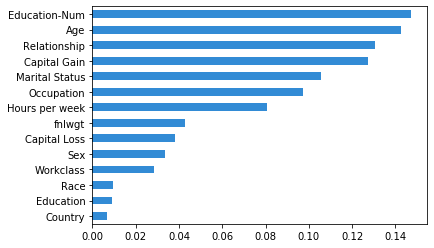

In [18]:
interpreter = Interpretation(training_data=X_test, feature_names=list(X_train.columns))

im_model = InMemoryModel(gbtree.predict_proba, examples=X_train, 
                         target_names=['$50K or less', 'More than $50K'])

plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

## PDP分析：
分别用skater和pdpbox两个工具来进行pdp分析

### AGE

[44/44] grid cells ████████████████████ Time elapsed: 0 seconds

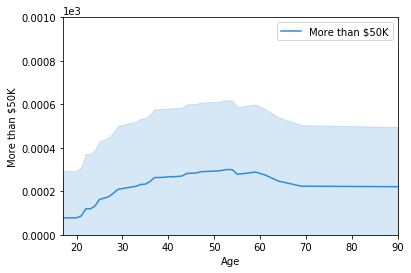

In [19]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

CPU times: user 1.24 s, sys: 10.4 ms, total: 1.25 s
Wall time: 1.26 s


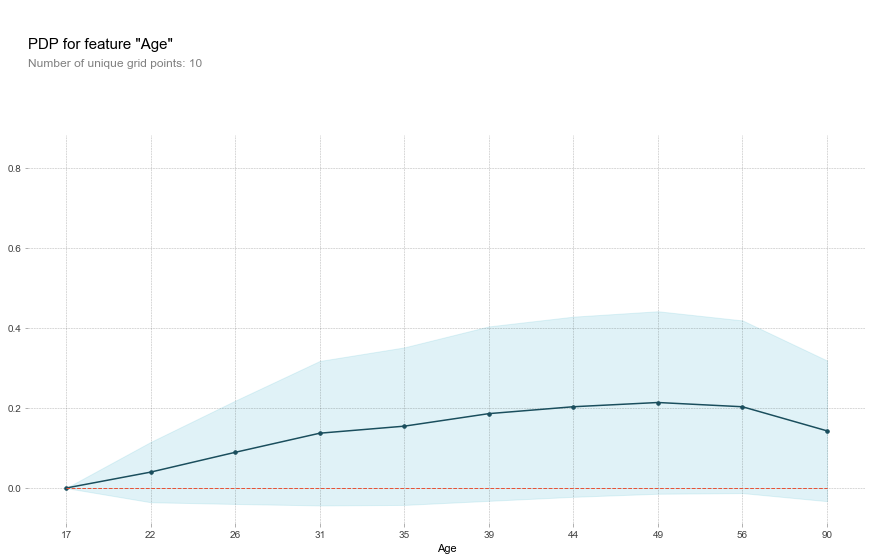

In [14]:
%%time
pdp_age = pdp.pdp_isolate(
    model=gbtree, dataset=X_test, model_features=feature_names, feature='Age'
)
fig, axes = pdp.pdp_plot(pdp_age, 'Age', x_quantile=True)

CPU times: user 10.7 s, sys: 78.6 ms, total: 10.8 s
Wall time: 10.8 s


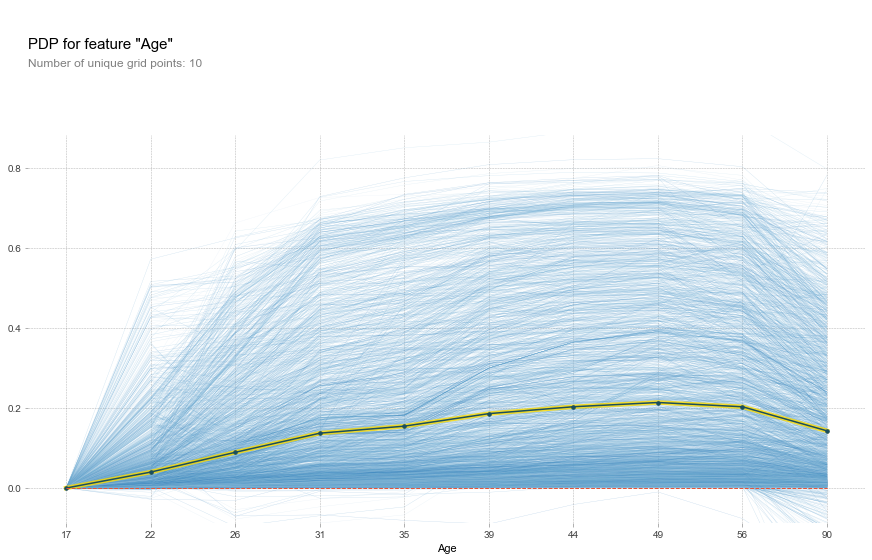

In [15]:
%%time
fig, axes = pdp.pdp_plot(
    pdp_age, 'Age', frac_to_plot=0.5, plot_lines=True, x_quantile=True,
)

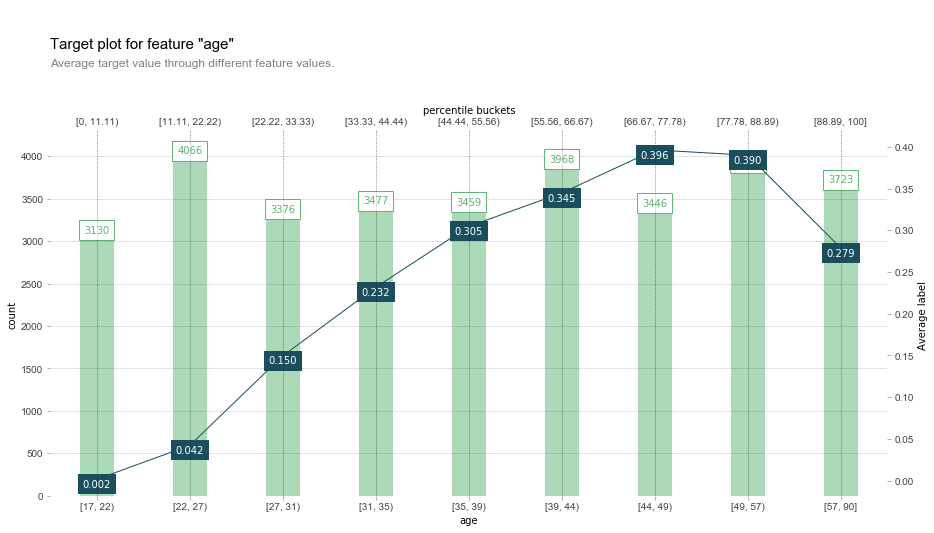

In [25]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='Age', feature_name='age', target='label', show_percentile=True
)

### Education-Num

[16/16] grid cells ████████████████████ Time elapsed: 0 seconds

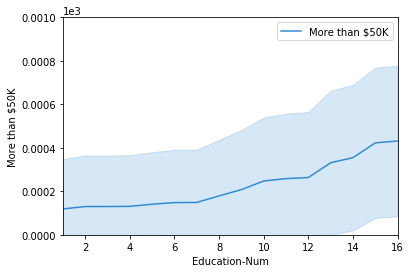

In [27]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

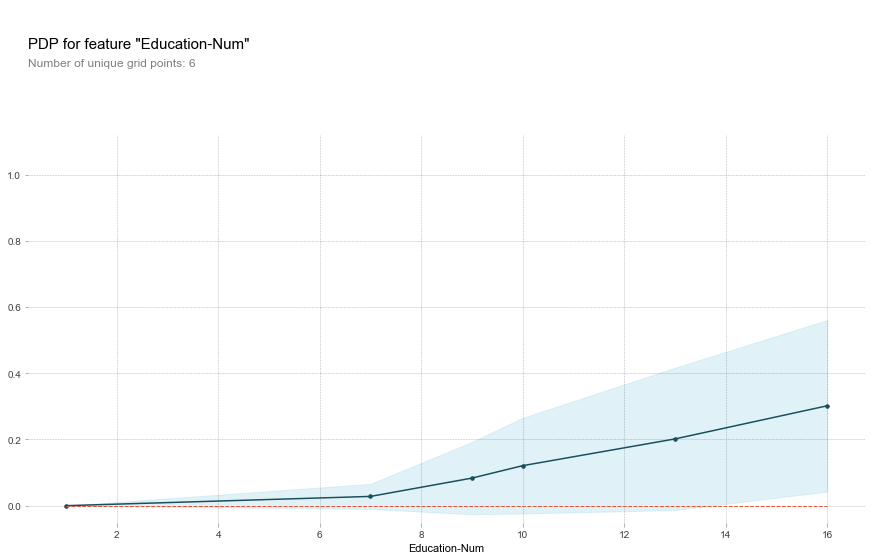

In [28]:
pdp_fare = pdp.pdp_isolate(
    model=gbtree, dataset=data, model_features=feature_names, feature='Education-Num'
)
fig, axes = pdp.pdp_plot(pdp_fare, 'Education-Num')

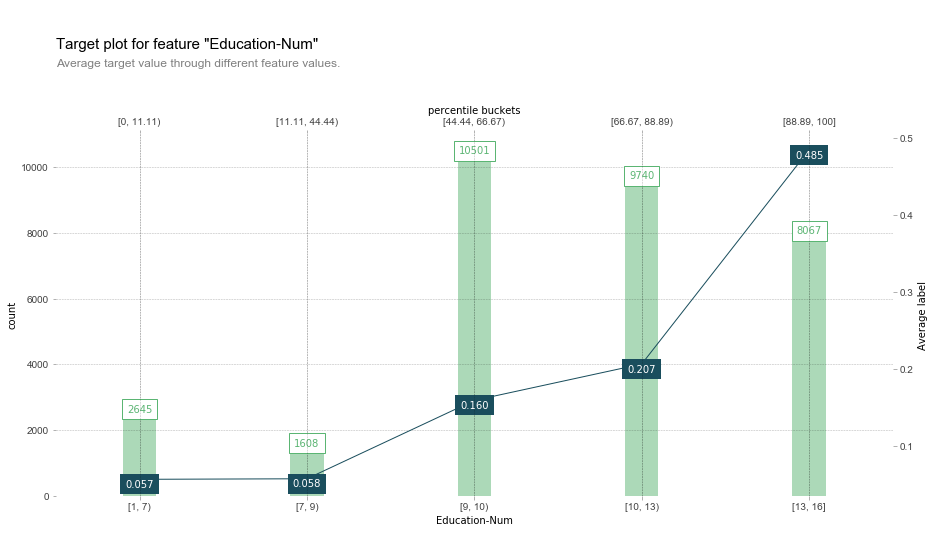

In [29]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='Education-Num', feature_name='Education-Num', target='label', show_percentile=True
)

### Age和Education-Num交互特征

[1120/1120] grid cells ████████████████████ Time elapsed: 7 seconds

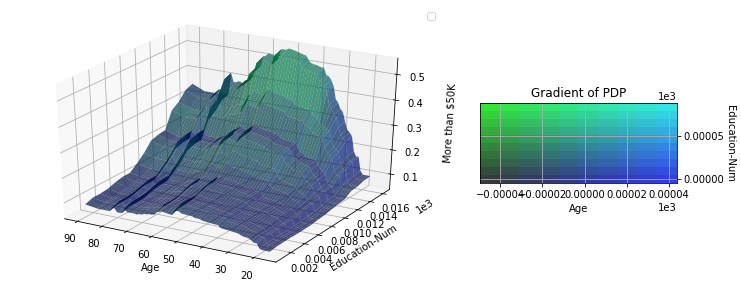

In [37]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

In [ ]:
inter1 = pdp.pdp_interact(
    model=gbtree, dataset=data, model_features=feature_names, features=['Age', 'Education-Num']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['Age', 'Education-Num'], plot_type='contour', x_quantile=True, plot_pdp=True
)

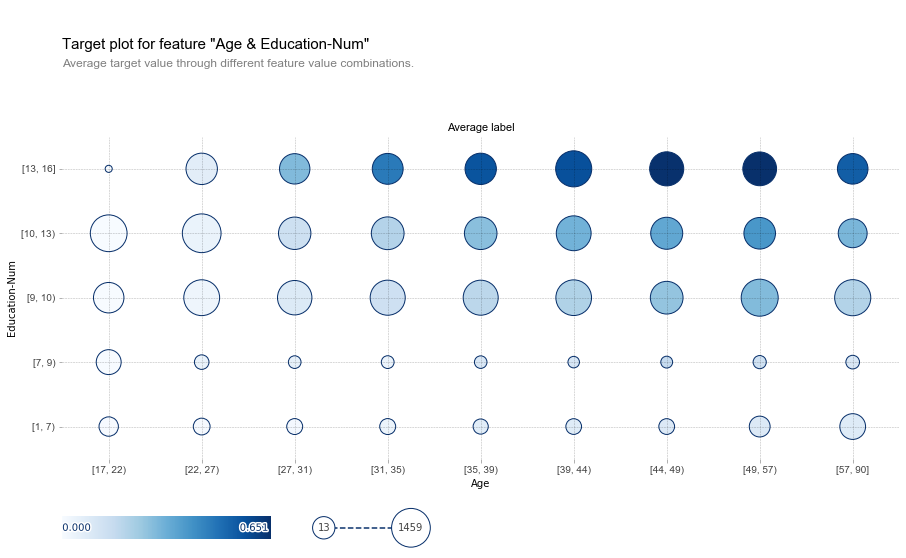

In [42]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=data, features=['Age', 'Education-Num'], feature_names=['Age', 'Education-Num'], target='label'
)

## SHAP

In [9]:
%%time
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(gbtree)
shap_values = explainer.shap_values(X_test)

# 对一个样本求shap值，各个特征对output所带来的变化
shap.force_plot(explainer.expected_value, shap_values[16,:], X_test.iloc[16,:])

CPU times: user 8.57 s, sys: 26.8 ms, total: 8.6 s
Wall time: 8.64 s


In [11]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])

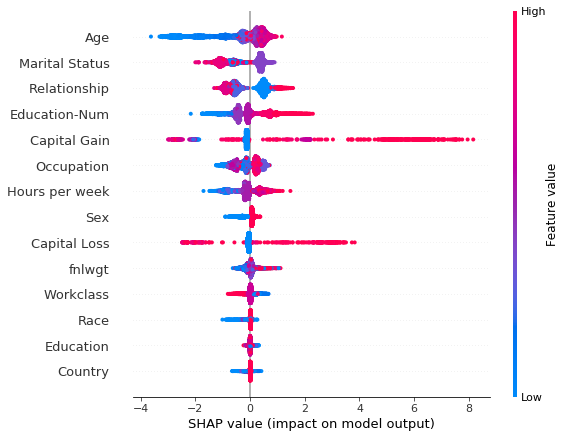

In [13]:
shap.summary_plot(shap_values, X_test)

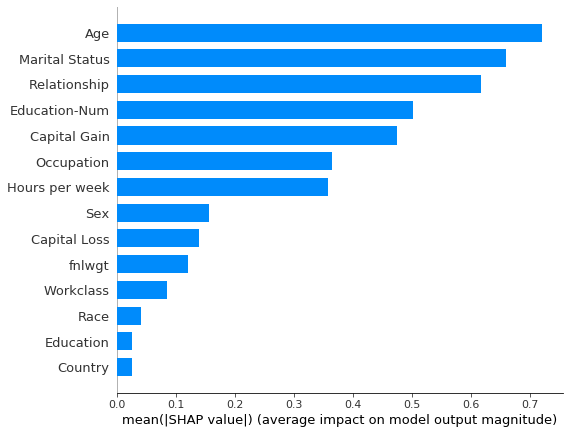

In [15]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

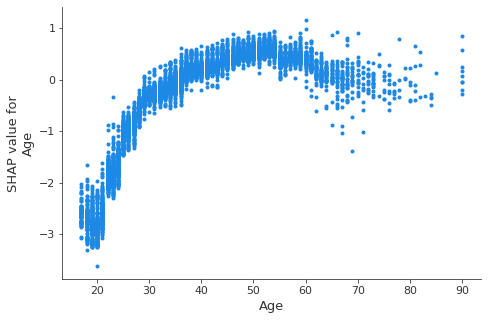

In [17]:
shap.dependence_plot("Age", shap_values, X_test, interaction_index=None)

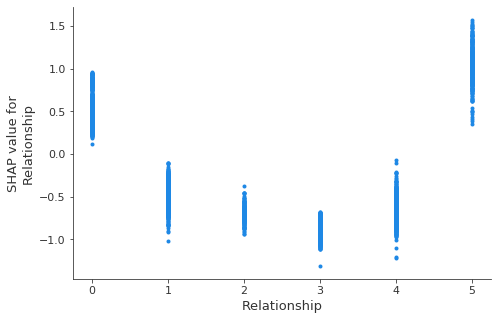

In [19]:
shap.dependence_plot("Relationship", shap_values, X_test,interaction_index=None)